In [1]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

### Initialize the environment

In [2]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity= -10.0,
    enable_wind= False,
    wind_power= 5.0,
    turbulence_power = 0.5,
)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Define Neural Network Architecture.

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Define hyperparameter

In [14]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [6]:
## Use GPU when it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent 

In [7]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### Training Process

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import torch
import time

def dqn(n_episodes=2000, max_t=1000, eps_start=0.85, eps_end=0.01, eps_decay=0.80):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    times = []                         # list containing training times per episode
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()       # start timer for episode
        state = env.reset()
        if isinstance(state, tuple):   # handle case where env.reset() returns a tuple
            state = state[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)  # unpack all returned values
            if isinstance(next_state, tuple):  # handle case where next_state is a tuple
                next_state = next_state[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done or truncated:  # break if the episode is done or truncated
                break 
        end_time = time.time()     # end timer for episode
        times.append(end_time - start_time)  # save training time for episode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tTraining Time: {:.2f}s'.format(i_episode, np.mean(scores_window), end_time - start_time))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, times

# Example usage
agent = Agent(state_size=8, action_size=4, seed=0)
scores, times = dqn()


Episode 100	Average Score: -230.66	Training Time: 1.75s
Episode 200	Average Score: -112.73	Training Time: 2.39s
Episode 300	Average Score: -95.10	Training Time: 0.10ss
Episode 400	Average Score: -94.50	Training Time: 1.64s
Episode 411	Average Score: -91.00	Training Time: 1.93s

KeyboardInterrupt: 

### Plot the learning progress

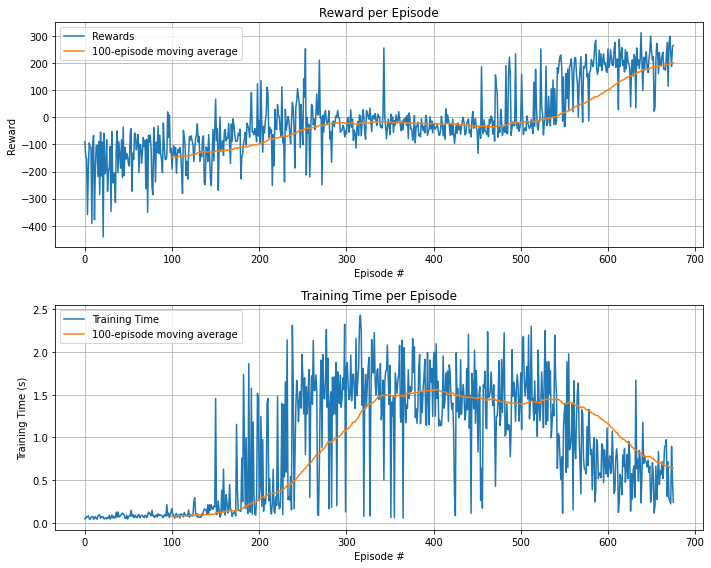

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scores_with_moving_average(scores, times, window_size=100):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the scores
    ax1.plot(np.arange(len(scores)), scores, label='Rewards')
    ax1.set_xlabel('Episode #')
    ax1.set_ylabel('Reward')
    ax1.tick_params(axis='y')
    ax1.grid()
    
    # Calculate the moving average
    if len(scores) >= window_size:
        moving_average = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(np.arange(window_size-1, len(scores)), moving_average, label=f'{window_size}-episode moving average')
    
    ax1.legend(loc='upper left')
    ax1.set_title('Reward per Episode')

    # Plot the training times
    ax2.plot(np.arange(len(times)), times, label='Training Time')
    ax2.set_xlabel('Episode #')
    ax2.set_ylabel('Training Time (s)')
    ax2.tick_params(axis='y')
    ax2.grid()
    
    # Calculate the moving average
    if len(times) >= window_size:
        moving_average_times = np.convolve(times, np.ones(window_size)/window_size, mode='valid')
        ax2.plot(np.arange(window_size-1, len(times)), moving_average_times, label=f'{window_size}-episode moving average')
    
    ax2.legend(loc='upper left')
    ax2.set_title('Training Time per Episode')

    fig.tight_layout()
    plt.show()

# Example usage
plot_scores_with_moving_average(scores, times)


### Test and animate it with Video

In [ ]:
import glob
import io
import base64
import torch
import gym
from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='human')
    env = RecordVideo(env, video_folder='video', episode_trigger=lambda x: True)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        if done or truncated:
            break
    env.close()
    env = None  # Ensure the environment is properly closed

def run_agent_episodes(agent, env_name, num_episodes=100):
    env = gym.make(env_name)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        rewards.append(total_reward)

    env.close()
    plot_rewards_statistics(rewards)

def plot_rewards_statistics(rewards):
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print('Average reward:', avg_reward)
    print('standard deviation:', std_reward)

    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(rewards, label='Reward per Episode',)
    plt.axhline(avg_reward, linestyle='--', label='Average Reward', color='red')
    plt.fill_between(range(len(rewards)), avg_reward - std_reward, avg_reward + std_reward, alpha=0.2, label='Standard Deviation', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards over 100 Episodes')
    plt.legend()
    plt.show()


Average reward: 235.33000593510445
standard deviation: 55.69098050059182


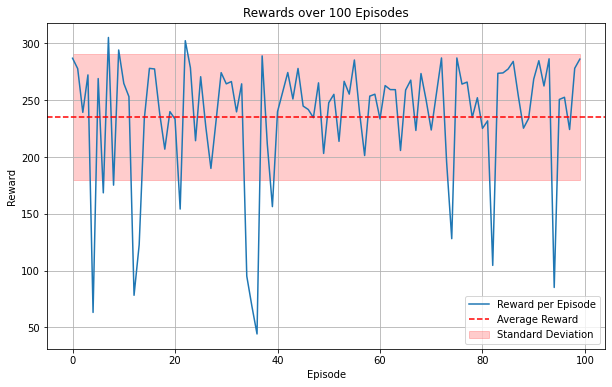

: 

In [ ]:

agent = Agent(state_size=8, action_size=4, seed=0)
run_agent_episodes(agent, 'LunarLander-v2')


In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/Users/olivierdullaert/opt/anaconda3/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/olivierdullaert/Documents/TU Delft/Msc. Aeropsace Engineering/Q4/Bio-isnpired Intelligence and learning for Aerospace applications - AE4350/Assignment/AE4350-Bio-Inspired/AE4350-Bio-Inspired/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/olivierdullaert/opt/anaconda3/lib/python3.8/site-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'video/LunarLander-v2.mp4'